# Introduction

Our input is the selected model with best paramaters <br/>


# Notebooks & dashboard

There are 5 different notebooks:
* __P7_EDA__: focusing on Exploratory Data Analysis,
* __P7_FE__: focusing on Feature engineering and a first model-agnostic Feature Selection,
* __P7_FS__: focusing on Feature Selecion,
* __P7_Model__ : focusing on scoring with model evaluation,
* __Current: P7_Interpretation__ : focusing on model interpretation, <br/>
And a dashboard python file.

# Forewords
In this Notebook, we study both LIME & SHAP interpretability techniques, building materials for the dashboard.

In [1]:
import pandas as pd
import pickle
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import lime
from lime.lime_tabular import LimeTabularExplainer

In [4]:
import shap

In [5]:
from sklearn.pipeline import make_pipeline

In [6]:
# load the model fitted
filename = 'Data/model.sav'
model = pickle.load(open(filename, 'rb'))

In [7]:
# check the model params
model

LGBMClassifier(boosting_type='goss', class_weight='balanced',
               learning_rate=0.01897824986309232, max_depth=23,
               n_estimators=610, num_leaves=52)

In [8]:
# create a pipe
pipe = make_pipeline(model)

In [9]:
# load target
with open("Data/final.pkl", mode="rb") as df:
    final = pickle.load(df)
print('New applications full shape: ', final.shape)

New applications full shape:  (48744, 128)


# Sample applications

In [10]:
final = final.sample(frac=0.2, random_state=42)

In [11]:
final.shape

(9749, 128)

# Make predictions

In [12]:
# predict the labels
y_pred = pipe.predict(final.drop(columns=['RISK_FLAG', 'RISK_PROBA']))

In [13]:
# check if failure is realistic applied on test set
pred_good = (y_pred == 0).sum()
pred_fail = (y_pred == 1).sum()
# control failure rate of y_pred
print('global failure rate: ',
     round(100 * pred_fail / (pred_good + pred_fail), 2))

global failure rate:  27.55


# Model's feature importances

In [14]:
# same with proba
y_proba = pipe.predict_proba(final.drop(columns=['RISK_FLAG', 'RISK_PROBA']))

In [15]:
# get feature importances from model
feature_importance_values = model.feature_importances_

In [16]:
# show feature importances sorted
feature_importances = pd.DataFrame({'feature': final.drop(columns=['RISK_FLAG', 'RISK_PROBA']).columns.to_list(), 'importance': feature_importance_values})

In [17]:
# overview of feature importances
feature_importances

feature  importance
0                                     N_CREDIT_TERM        1331
1                                       YEARS_BIRTH         735
2                            DAYS_LAST_PHONE_CHANGE         613
3                                       AMT_ANNUITY         634
4                                        AMT_CREDIT         421
..                                              ...         ...
121                  BUR_AMT_CREDIT_MAX_OVERDUE_MAX         126
122           ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_SUM         130
123                          ACTIVE_DAYS_CREDIT_MIN         152
124                        PREV_AMT_APPLICATION_MAX         151
125  INSAGG_INS_N_PREV_EARLINESS_OVERDUE_RATIO_MEAN         163

[126 rows x 2 columns]

# Predicted failure rate

In [18]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [19]:
# labels for best threshold
y_pred = to_labels(y_proba, 0.5)[:, 1]

In [20]:
# check if failure is realistic applied on test set
pred_good = (y_pred == 0).sum()
pred_fail = (y_pred == 1).sum()
print('failure rate on entire test set: ', pred_fail / (pred_good + pred_fail))

failure rate on entire test set:  0.27551543748076723


In [21]:
failure_rate = pred_fail / (pred_good + pred_fail)

In [22]:
failure_rate

0.27551543748076723

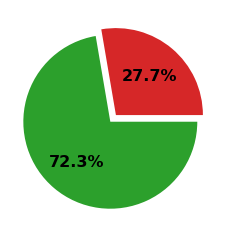

In [21]:
plt.pie(
    [failure_rate, 1 - failure_rate],
    colors=('tab:red', 'tab:green'),
    autopct='%1.1f%%',
    explode=(0, 0.1),
    textprops={'fontsize': 16,
               'weight': 'bold'}
)
plt.show()

## Prepare data manipulation

In [23]:
inputs = final.drop(columns=['RISK_FLAG', 'RISK_PROBA'])

In [26]:
inputs.loc[[235651]]

N_CREDIT_TERM  YEARS_BIRTH  DAYS_LAST_PHONE_CHANGE  AMT_ANNUITY  \
SK_ID_CURR                                                                    
149596           0.042522    27.964384                 -2513.0      36090.0   

            AMT_CREDIT  DAYS_EMPLOYED  AMT_GOODS_PRICE  DAYS_ID_PUBLISH  \
SK_ID_CURR                                                                
149596        848745.0         -737.0         675000.0          -1732.0   

            N_ANNUITY_INCOME_RATIO  BUR_DAYS_CREDIT_MEAN  ...  \
SK_ID_CURR                                                ...   
149596                    0.534667               -1310.6  ...   

            CLOSED_DAYS_CREDIT_ENDDATE_MIN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                        
149596                             -1643.0              47767.5   

            PREV_N_ADJ_INTEREST_EVAL_MEAN  \
SK_ID_CURR                                  
149596                          -0.044772   

            INSAGG_INS_N_PREV_LAST_DAYS_INSTALMENT_SUM  \
SK_ID_CURR                                               
149596                                        -26760.0   

            APPROVED_NC_LOAN_AGE_MEAN  BUR_AMT_CREDIT_MAX_OVERDUE_MAX  \
SK_ID_CURR                                                              
149596                       3.958333                             0.0   

            ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_SUM  ACTIVE_DAYS_CREDIT_MIN  \
SK_ID_CURR                                                                  
149596                                   0.511143                 -1152.0   

            PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                             
149596                      130342.5   

            INSAGG_INS_N_PREV_EARLINESS_OVERDUE_RATIO_MEAN  
SK_ID_CURR                                                  
149596                                              0.5625  

[1 rows x 126 columns]

In [27]:
inputs.index.get_loc(235651)

6912

In [28]:
inputs.iloc[[6912]]

N_CREDIT_TERM  YEARS_BIRTH  DAYS_LAST_PHONE_CHANGE  AMT_ANNUITY  \
SK_ID_CURR                                                                    
149596           0.042522    27.964384                 -2513.0      36090.0   

            AMT_CREDIT  DAYS_EMPLOYED  AMT_GOODS_PRICE  DAYS_ID_PUBLISH  \
SK_ID_CURR                                                                
149596        848745.0         -737.0         675000.0          -1732.0   

            N_ANNUITY_INCOME_RATIO  BUR_DAYS_CREDIT_MEAN  ...  \
SK_ID_CURR                                                ...   
149596                    0.534667               -1310.6  ...   

            CLOSED_DAYS_CREDIT_ENDDATE_MIN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                        
149596                             -1643.0              47767.5   

            PREV_N_ADJ_INTEREST_EVAL_MEAN  \
SK_ID_CURR                                  
149596                          -0.044772   

            INSAGG_INS_N_PREV_LAST_DAYS_INSTALMENT_SUM  \
SK_ID_CURR                                               
149596                                        -26760.0   

            APPROVED_NC_LOAN_AGE_MEAN  BUR_AMT_CREDIT_MAX_OVERDUE_MAX  \
SK_ID_CURR                                                              
149596                       3.958333                             0.0   

            ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_SUM  ACTIVE_DAYS_CREDIT_MIN  \
SK_ID_CURR                                                                  
149596                                   0.511143                 -1152.0   

            PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                             
149596                      130342.5   

            INSAGG_INS_N_PREV_EARLINESS_OVERDUE_RATIO_MEAN  
SK_ID_CURR                                                  
149596                                              0.5625  

[1 rows x 126 columns]

In [29]:
idx = inputs.loc[[149596]].index.to_numpy()

In [30]:
inputs['CODE_GENDER'].dtypes

dtype('float64')

In [31]:
pipe.predict_proba(inputs.loc[[149596]])

array([[0.62326195, 0.37673805]])

In [32]:
pipe.predict(inputs.loc[[149596]])

array([0.])

In [33]:
threshold = 0.5

In [108]:
final[final['RISK_PROBA'] > threshold].sample(3)

RISK_FLAG  RISK_PROBA  N_CREDIT_TERM  YEARS_BIRTH  \
SK_ID_CURR                                                      
366921              1    0.637519       0.079420    27.369863   
235651              1    0.578719       0.079240    30.027397   
402258              1    0.642299       0.077941    37.435616   

            DAYS_LAST_PHONE_CHANGE  AMT_ANNUITY  AMT_CREDIT  DAYS_EMPLOYED  \
SK_ID_CURR                                                                   
366921                         0.0      24840.0    312768.0        -3280.0   
235651                      -363.0      44572.5    562500.0        -1578.0   
402258                         0.0      17887.5    229500.0         -141.0   

            AMT_GOODS_PRICE  DAYS_ID_PUBLISH  ...  \
SK_ID_CURR                                    ...   
366921             270000.0          -2652.0  ...   
235651             562500.0          -2417.0  ...   
402258             229500.0          -3951.0  ...   

            CLOSED_DAYS_CREDIT_ENDDATE_MIN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                        
366921                             -1449.0              24304.5   
235651                               -56.0              87129.9   
402258                             -1529.0              25825.5   

            PREV_N_ADJ_INTEREST_EVAL_MEAN  \
SK_ID_CURR                                  
366921                           0.002924   
235651                           0.000000   
402258                           0.024231   

            INSAGG_INS_N_PREV_LAST_DAYS_INSTALMENT_SUM  \
SK_ID_CURR                                               
366921                                        -28752.0   
235651                                          -870.0   
402258                                         -5928.0   

            APPROVED_NC_LOAN_AGE_MEAN  BUR_AMT_CREDIT_MAX_OVERDUE_MAX  \
SK_ID_CURR                                                              
366921                       5.916667                    23625.000000   
235651                       0.916667                     9012.323354   
402258                       2.458333                        0.000000   

            ACTIVE_N_BUR_AMT_CREDIT_DEBT_RATE_SUM  ACTIVE_DAYS_CREDIT_MIN  \
SK_ID_CURR                                                                  
366921                                   1.271589             -765.000000   
235651                                 406.259677             -940.042198   
402258                                   3.225739             -391.000000   

            PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                             
366921                      160200.0   
235651                       87129.9   
402258                      193333.5   

            INSAGG_INS_N_PREV_EARLINESS_OVERDUE_RATIO_MEAN  
SK_ID_CURR                                                  
366921                                            0.000000  
235651                                            0.111111  
402258                                            0.000000  

[3 rows x 128 columns]

# Local Interpretable Model-Agnostic Explanations

https://lime-ml.readthedocs.io/ <br/>
https://arxiv.org/pdf/1602.04938.pdf


In [32]:
help(LimeTabularExplainer)

Help on class LimeTabularExplainer in module lime.lime_tabular:

class LimeTabularExplainer(builtins.object)
 |  LimeTabularExplainer(training_data, mode='classification', training_labels=None, feature_names=None, categorical_features=None, categorical_names=None, kernel_width=None, kernel=None, verbose=False, class_names=None, feature_selection='auto', discretize_continuous=True, discretizer='quartile', sample_around_instance=False, random_state=None, training_data_stats=None)
 |  
 |  Explains predictions on tabular (i.e. matrix) data.
 |  For numerical features, perturb them by sampling from a Normal(0,1) and
 |  doing the inverse operation of mean-centering and scaling, according to the
 |  means and stds in the training data. For categorical features, perturb by
 |  sampling according to the training distribution, and making a binary
 |  feature that is 1 when the value is the same as the instance being
 |  explained.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, training

In [35]:
# give a name to binary classes
class_names = ['0: Low Risk','1: Failure Risk']
# categorcial features (from Model notebook)
categorical_features = [17, 60, 71]

In [36]:
# create explainer
explainer = LimeTabularExplainer(
    training_data = inputs.values,
    mode='classification',
    training_labels = final['RISK_FLAG'],
    feature_names = inputs.columns,
    class_names=class_names,
    categorical_features=categorical_features)

In [37]:
# check it
explainer

In [38]:
# lime explanation with i as SK_ID_CURR value (application - client)
def explanation(i):
    exp = explainer.explain_instance(
        inputs.loc[i].values,
        pipe.predict_proba,
        num_features=10)
    exp.show_in_notebook(predict_proba=True, show_predicted_value=True, show_table=True, show_all=False)
    return exp

In [109]:
# sample 
exp_test = explanation(235651)

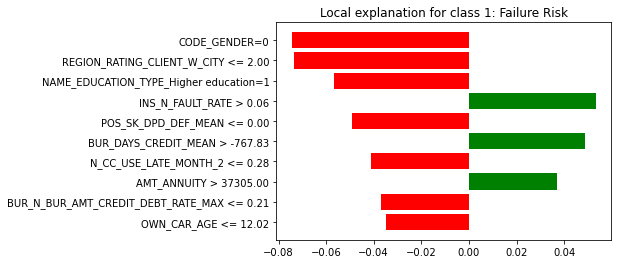

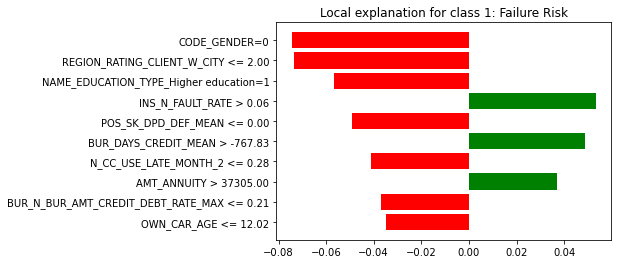

In [110]:
# same with "basic plot"
exp_test.as_pyplot_figure()

Here we see that green color is applied when feature "supports" the class prediction. Our concern is that Class 1 means risk of failure and represented by red color all along our study : we change it.

In [111]:
# get the original data to change colors
exp = exp_test.as_list()

In [112]:
vals = [x[1] for x in exp]
names = [x[0] for x in exp]

In [113]:
vals

[-0.07447973945075574,
 -0.07342274243432985,
 -0.056534887574819205,
 0.05340963316501071,
 -0.049239246084125596,
 0.048647851193940196,
 -0.041233553295803936,
 0.03701948091011781,
 -0.03693540215647452,
 -0.03468020414328048]

In [114]:
vals.reverse()
names.reverse()

In [115]:
vals

[-0.03468020414328048,
 -0.03693540215647452,
 0.03701948091011781,
 -0.041233553295803936,
 0.048647851193940196,
 -0.049239246084125596,
 0.05340963316501071,
 -0.056534887574819205,
 -0.07342274243432985,
 -0.07447973945075574]

In [116]:
pos = np.arange(len(exp)) + .5

Text(0.5, 1.0, 'Local explanation for Class 1: Failure Risk')

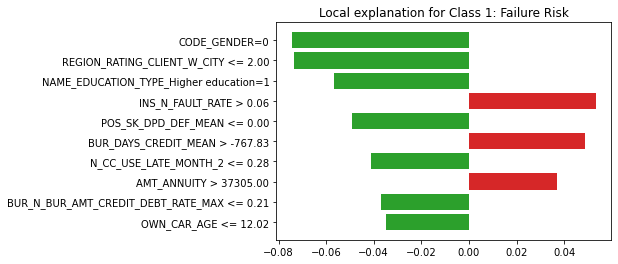

In [117]:
# new figure
fig = plt.figure()
colors = ['tab:red' if x > 0 else 'tab:green' for x in vals]

plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
plt.title('Local explanation for Class 1: Failure Risk')

In [118]:
# now we want cols index and we get it from dict "as_map()"
map_test = exp_test.as_map()

In [119]:
# show the dict 
map_test[1]

[(17, -0.07447973945075574),
 (36, -0.07342274243432985),
 (60, -0.056534887574819205),
 (21, 0.05340963316501071),
 (66, -0.049239246084125596),
 (9, 0.048647851193940196),
 (35, -0.041233553295803936),
 (3, 0.03701948091011781),
 (45, -0.03693540215647452),
 (11, -0.03468020414328048)]

In [120]:
# get the cols
cols = [item[0] for item in map_test[1]]

In [121]:
# check the cols
cols

[17, 36, 60, 21, 66, 9, 35, 3, 45, 11]

In [122]:
# get the feature to show
features_to_show = inputs.columns[cols].tolist()

In [123]:
# check a selection
inputs.filter(features_to_show).loc[[149596]]

CODE_GENDER  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                                             
149596              0.0                          3.0   

            NAME_EDUCATION_TYPE_Higher education  INS_N_FAULT_RATE  \
SK_ID_CURR                                                           
149596                                       0.0            0.5625   

            POS_SK_DPD_DEF_MEAN  BUR_DAYS_CREDIT_MEAN  N_CC_USE_LATE_MONTH_2  \
SK_ID_CURR                                                                     
149596                      0.0               -1310.6               0.278956   

            AMT_ANNUITY  BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX  OWN_CAR_AGE  
SK_ID_CURR                                                                
149596          36090.0                            0.511143    12.023766

In [124]:
# translate as index toprocess the same with SHAP technique
inputs.index.get_loc(149596)

6912

In [125]:
# reduce df
df_lime = inputs.filter(features_to_show)

In [126]:
df_lime.loc[[149596]]

CODE_GENDER  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                                             
149596              0.0                          3.0   

            NAME_EDUCATION_TYPE_Higher education  INS_N_FAULT_RATE  \
SK_ID_CURR                                                           
149596                                       0.0            0.5625   

            POS_SK_DPD_DEF_MEAN  BUR_DAYS_CREDIT_MEAN  N_CC_USE_LATE_MONTH_2  \
SK_ID_CURR                                                                     
149596                      0.0               -1310.6               0.278956   

            AMT_ANNUITY  BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX  OWN_CAR_AGE  
SK_ID_CURR                                                                
149596          36090.0                            0.511143    12.023766

## Compare client value with class 0 - class 1 & neighbors values

In this section we tried to identify the client value into violin plots for any features... facts is that formating to the same scale, implies many processing an we were finally not able to emphasize client's value within the plot.

In [127]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
df_lime_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_lime.values), index=df_lime.index, columns=df_lime.columns)
scale = MinMaxScaler().fit_transform(df_lime.values)
scale_quant = QuantileTransformer().fit_transform(scale)
df_lime_quant = pd.DataFrame(scale_quant, index=df_lime.index, columns=df_lime.columns)

(array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

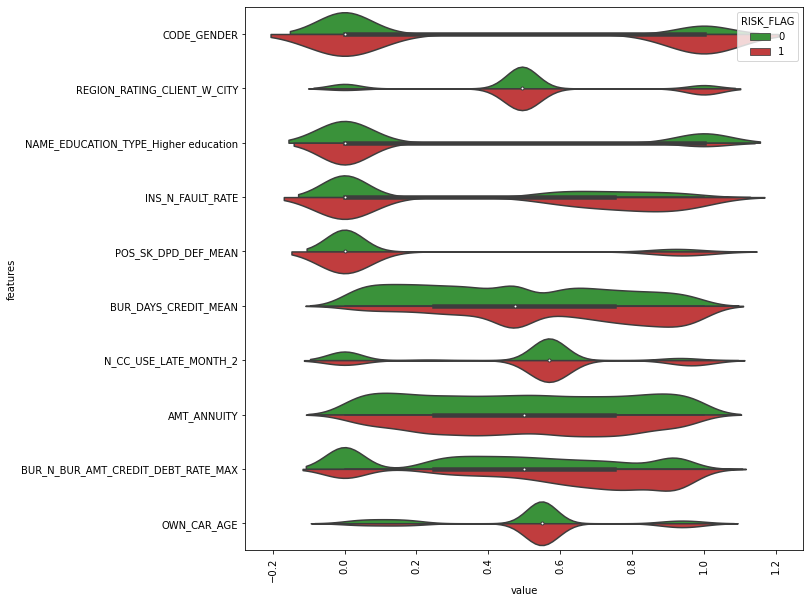

In [128]:
# y include risk_flag with value 0 or 1
y = final['RISK_FLAG']
data = pd.concat([y, df_lime_quant], axis=1)
data = pd.melt(data, id_vars='RISK_FLAG',
 var_name='features',
 value_name='value')
# make a violin plot
plt.figure(figsize=(10,10))
sns.violinplot(x='value', y='features', hue='RISK_FLAG', palette=['tab:green', 'tab:red'], data=data, split=True, scale='width')
plt.xticks(rotation=90)

## Create list of neighbors

we want to get a more local comparison of client's values againts the same clients. we proceed with the restricted-to-features values, in order to detect "anomaly" : what client value could explain the gap.

In [129]:
from sklearn.neighbors import NearestNeighbors

In [130]:
# get neighbors list
nearest_neighbors = NearestNeighbors(n_neighbors=20, radius=0.4)
nearest_neighbors.fit(df_lime)

NearestNeighbors(n_neighbors=20, radius=0.4)

In [131]:
neighbors = nearest_neighbors.kneighbors(df_lime.loc[[149596]], 21, return_distance=False)[0]

In [132]:
neighbors

array([6912, 7549,  689, 7411, 7913, 2041, 1061,  637, 5194, 3731, 8692,
       7649, 4566, 2753, 5485, 9173, 1318, 8851, 2222, 8684, 1248],
      dtype=int64)

In [133]:
# remove our current observation
neighbors = np.delete(neighbors, 0)

In [134]:
df_lime['RISK_FLAG'] = final['RISK_FLAG']

In [135]:
# restricted^2 dataframe
df_neighbors = df_lime.iloc[neighbors]

In [136]:
df_neighbors.shape

(20, 11)

In [137]:
# compute mean values
neighbors_values = pd.DataFrame(df_neighbors.mean(), index=df_neighbors.columns, columns=['neighbors_mean'])

In [138]:
# create df
neighbors_values = pd.DataFrame(
                df_lime.iloc[neighbors].mean(),
                index=df_lime.columns,
                columns=['Neighbors_Mean'])

In [139]:
# overview neighbors_values
neighbors_values

Neighbors_Mean
CODE_GENDER                                 0.150000
REGION_RATING_CLIENT_W_CITY                 2.150000
NAME_EDUCATION_TYPE_Higher education        0.250000
INS_N_FAULT_RATE                            0.052221
POS_SK_DPD_DEF_MEAN                         0.050181
BUR_DAYS_CREDIT_MEAN                    -1281.435105
N_CC_USE_LATE_MONTH_2                       0.277258
AMT_ANNUITY                             36047.250000
BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX          1.746616
OWN_CAR_AGE                                11.119013
RISK_FLAG                                   0.200000

In [140]:
neighbors_values.Neighbors_Mean.tail(1).values[0]

0.2

In [141]:
# same with our client's application
df_individual = df_lime.loc[[149596]]

In [142]:
individual_values = df_individual.T 

In [143]:
individual_values

SK_ID_CURR                                  149596
CODE_GENDER                               0.000000
REGION_RATING_CLIENT_W_CITY               3.000000
NAME_EDUCATION_TYPE_Higher education      0.000000
INS_N_FAULT_RATE                          0.562500
POS_SK_DPD_DEF_MEAN                       0.000000
BUR_DAYS_CREDIT_MEAN                  -1310.600000
N_CC_USE_LATE_MONTH_2                     0.278956
AMT_ANNUITY                           36090.000000
BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX        0.511143
OWN_CAR_AGE                              12.023766
RISK_FLAG                                 0.000000

In [144]:
individual_values.columns = ['client']

In [145]:
individual_values

client
CODE_GENDER                               0.000000
REGION_RATING_CLIENT_W_CITY               3.000000
NAME_EDUCATION_TYPE_Higher education      0.000000
INS_N_FAULT_RATE                          0.562500
POS_SK_DPD_DEF_MEAN                       0.000000
BUR_DAYS_CREDIT_MEAN                  -1310.600000
N_CC_USE_LATE_MONTH_2                     0.278956
AMT_ANNUITY                           36090.000000
BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX        0.511143
OWN_CAR_AGE                              12.023766
RISK_FLAG                                 0.000000

In [146]:
class1_values = pd.DataFrame(
    df_lime[df_lime['RISK_FLAG'] == 1].mean(), index=df_lime.columns, columns=['class1_mean'])

In [147]:
class1_values.iloc[:-1]

class1_mean
CODE_GENDER                               0.471333
REGION_RATING_CLIENT_W_CITY               2.152271
NAME_EDUCATION_TYPE_Higher education      0.136262
INS_N_FAULT_RATE                          0.074033
POS_SK_DPD_DEF_MEAN                       0.089662
BUR_DAYS_CREDIT_MEAN                   -886.936619
N_CC_USE_LATE_MONTH_2                     0.358045
AMT_ANNUITY                           28858.070419
BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX      610.740007
OWN_CAR_AGE                              12.669668

In [148]:
class0_values = pd.DataFrame(
    df_lime[df_lime['RISK_FLAG'] == 0].mean(), index=df_lime.columns, columns=['class0_mean'])

In [149]:
class0_values.iloc[:-1] 

class0_mean
CODE_GENDER                               0.276795
REGION_RATING_CLIENT_W_CITY               1.958941
NAME_EDUCATION_TYPE_Higher education      0.301855
INS_N_FAULT_RATE                          0.039676
POS_SK_DPD_DEF_MEAN                       0.066783
BUR_DAYS_CREDIT_MEAN                  -1164.392932
N_CC_USE_LATE_MONTH_2                     0.242942
AMT_ANNUITY                           29575.453501
BUR_N_BUR_AMT_CREDIT_DEBT_RATE_MAX      185.695551
OWN_CAR_AGE                              11.732630

In [150]:
any_values = pd.concat([class0_values.iloc[:-1], class1_values.iloc[:-1], neighbors_values, individual_values], axis=1)

In [151]:
any_values.index[2]

'NAME_EDUCATION_TYPE_Higher education'

In [152]:
to_plot = any_values.T

In [153]:
any_values.T.iloc[:, 2]

class0_mean       0.301855
class1_mean       0.136262
Neighbors_Mean    0.250000
client            0.000000
Name: NAME_EDUCATION_TYPE_Higher education, dtype: float64

Text(0.5, 1.0, 'Local explanation for Class 1: Failure Risk')

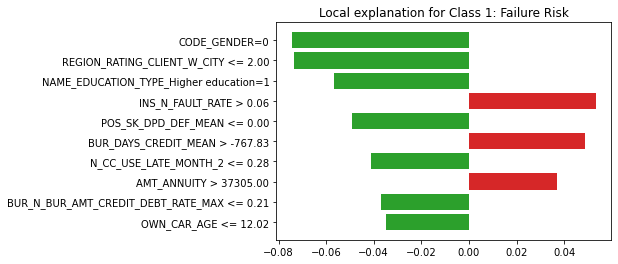

In [154]:
# new figure
fig = plt.figure()
vals = [x[1] for x in exp]
names = [x[0] for x in exp]
face_colors = ['#fee0d2' if x > 0 else '#c7e9c0' for x in vals]
vals.reverse()
names.reverse()
colors = ['tab:red' if x > 0 else 'tab:green' for x in vals]
pos = np.arange(len(exp)) + .5
plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
plt.title('Local explanation for Class 1: Failure Risk')

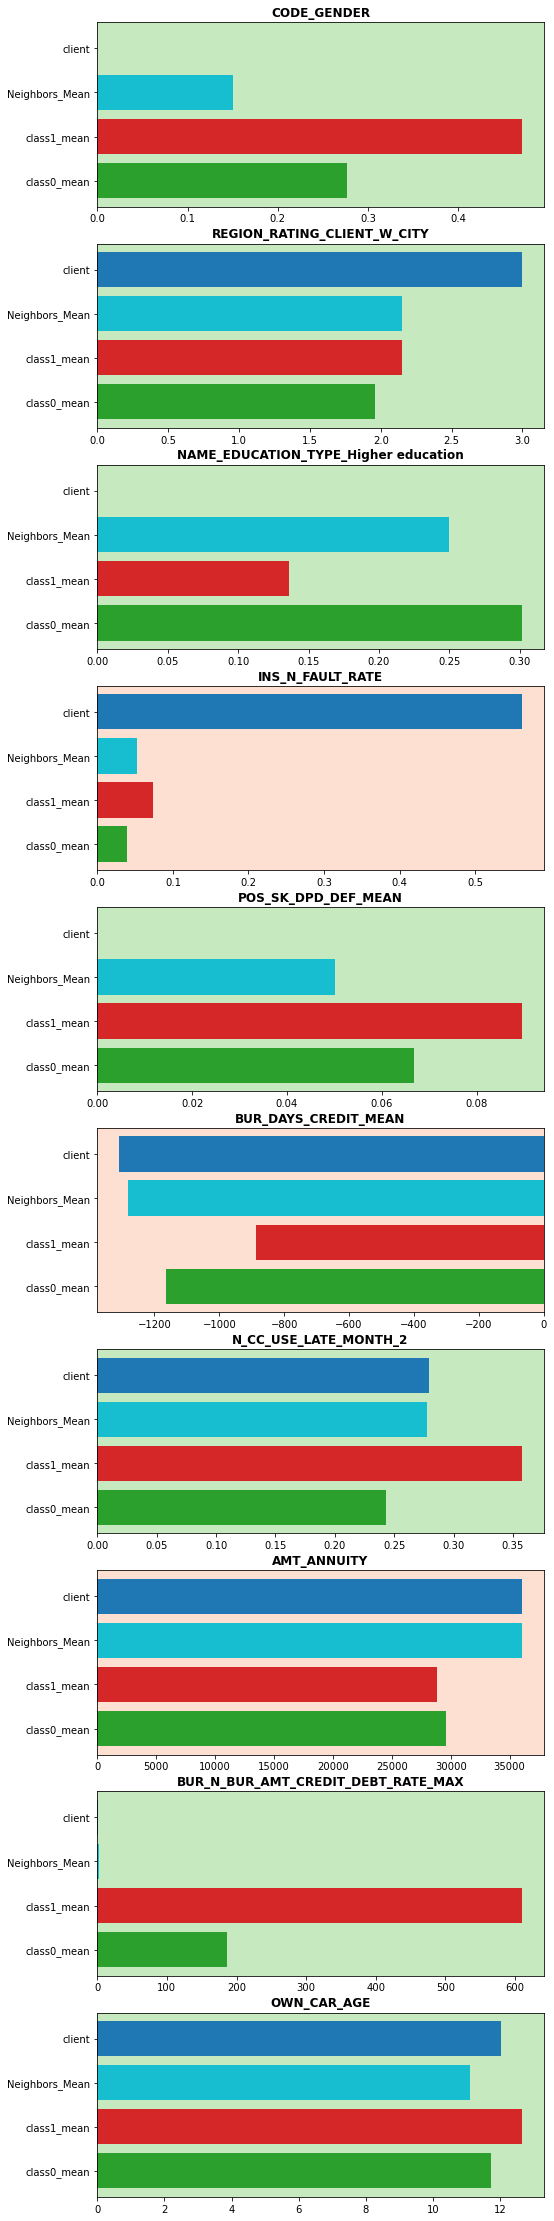

In [155]:
# overview of features values to compare client with the 3 other groups.
# the foreground colors tells if supports the failure risk prediction red or contradicts
colorsList = ('tab:green', 'tab:red', 'tab:cyan', 'tab:blue')
fig, axs = plt.subplots(10, sharey='row', figsize=(8, 40))
axgb_colors = []
for i in np.arange(0, 10):
    axs[i].barh(any_values.T.index,
                any_values.T.iloc[:, i],
                color=colorsList)
    axs[i].set_title(str(any_values.index[i]), fontweight="bold")
    axs[i].patch.set_facecolor(face_colors[i])
plt.show()

# SHAP

https://shap.readthedocs.io/

In [87]:
help(shap.TreeExplainer)

Help on class Tree in module shap.explainers._tree:

class Tree(shap.explainers._explainer.Explainer)
 |  Tree(model, data=None, model_output='raw', feature_perturbation='interventional', **deprecated_options)
 |  
 |  Uses Tree SHAP algorithms to explain the output of ensemble tree models.
 |  
 |  Tree SHAP is a fast and exact method to estimate SHAP values for tree models and ensembles of trees,
 |  under several different possible assumptions about feature dependence. It depends on fast C++
 |  implementations either inside an externel model package or in the local compiled C extention.
 |  
 |  Parameters
 |  ----------
 |  model : model object
 |      The tree based machine learning model that we want to explain. XGBoost, LightGBM, CatBoost, Pyspark
 |      and most tree-based scikit-learn models are supported.
 |  
 |  data : numpy.array or pandas.DataFrame
 |      The background dataset to use for integrating out features. This argument is optional when
 |      feature_perturba

In [93]:
inputs.values

array([[ 4.25209367e-02,  3.10904110e+01, -7.30000000e+02, ...,
        -9.40042198e+02,  3.66043500e+05,  0.00000000e+00],
       [ 6.43377886e-02,  5.43890411e+01, -6.93000000e+02, ...,
        -1.82900000e+03,  5.80500000e+05,  0.00000000e+00],
       [ 1.04998412e-01,  4.14739726e+01, -2.31000000e+02, ...,
        -2.58500000e+03,  6.30000000e+05,  0.00000000e+00],
       ...,
       [ 5.75736884e-02,  6.03726027e+01,  0.00000000e+00, ...,
        -9.40042198e+02,  1.12500000e+05,  2.39130435e-01],
       [ 5.14714286e-02,  4.62904110e+01, -2.53200000e+03, ...,
        -7.27000000e+02,  3.59550000e+04,  0.00000000e+00],
       [ 6.38997079e-02,  4.47534247e+01, -2.65400000e+03, ...,
        -4.80000000e+02,  6.75000000e+05,  1.07116833e-01]])

In [94]:
# create explainer
explainerModel = shap.TreeExplainer(
    model=model,
    data=inputs.values,
    model_output='probability')

In [95]:
explainerModel

In [96]:
# save the shap explainer
filename = 'Data/shap_alternate.exp'
pickle.dump(explainerModel, open(filename, 'wb'))

In [97]:
shap_values_Model = explainerModel.shap_values(inputs.values)

100%|===================| 9748/9749 [07:36<00:00]        

In [100]:
# save the shap values
filename = 'Data/shap_alternate.val'
pickle.dump(shap_values_Model, open(filename, 'wb'))

In [101]:
shap_values_Model

array([[-1.01777400e-02,  1.16477093e-02, -6.85813315e-03, ...,
         1.91884405e-05,  3.85247003e-04, -6.53591483e-04],
       [-1.43496857e-03, -1.48058027e-02, -1.27218406e-03, ...,
         2.40053707e-04,  9.08374657e-04, -3.07717942e-04],
       [-8.57999692e-02,  1.21544211e-03,  1.35351888e-02, ...,
         3.63214503e-04,  2.35743761e-04,  3.08992262e-04],
       ...,
       [-1.93286777e-02, -3.23465896e-02,  3.89075937e-02, ...,
        -4.92824810e-05, -1.06584739e-03, -7.02411741e-04],
       [ 1.21260104e-02, -2.20300608e-02, -2.56065266e-02, ...,
        -1.68140362e-05, -1.96021021e-03, -1.05165861e-04],
       [-2.33858388e-03,  6.02183090e-04, -2.62186379e-02, ...,
         2.13182694e-04,  9.58217917e-04, -3.60524482e-04]])

In [102]:
shap.initjs()

In [103]:
# compute shap_values
shap_values = shap_values_Model

In [104]:
j = 6912

In [105]:
shap.force_plot(explainerModel.expected_value, shap_values_Model[j], inputs.iloc[[j]], plot_cmap="PkYg")

In [106]:
shap.force_plot(explainerModel.expected_value, shap_values_Model[0,:], inputs.iloc[0,:], plot_cmap="PkYg")

In [156]:
# force plot collectif, sur un sample des 500 premières données
shap.force_plot(explainerModel.expected_value, shap_values[:500,:], inputs.iloc[:500,:], plot_cmap="PkYg")